In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time
import scienceplots
import scipy as sc
import scipy.special as sp
import scipy.linalg as la

plt.style.use('science')

sledi originalna rešitev, ki mi je dvakrat pojedla ves spomin in crashala računalnik

In [85]:
M, N = 100, 100

def make_A(M, N):
    A = np.zeros((M, N, N))
    for m in range(M):
        for n in range(1, N+1):
            for n_ in range(1, N+1):
                A[m, n-1, n_-1] = -np.pi/2 * (n*n_) * (3. + 4.*m) / (2. + 4.*m + n + n_) * sp.beta(n + n_ - 1, 3 + 4 * m)
    A_block = sc.linalg.block_diag(*[A[m] for m in range(M)])
    return A_block

import scipy.linalg as la

def make_A(M, N):
    n = np.arange(1, N+1)                      # (N,)
    n1, n2 = np.meshgrid(n, n, indexing="ij")   # (N,N), (N,N)
    nn = n1 * n2
    s = n1 + n2                                # n + n'

    blocks = []

    for m in range(M):
        a = 3 + 4*m

        # Beta(s-1, a) for all (n,n')
        B = sp.beta(s - 1, a)

        A_m = -np.pi/2 * nn * a / (2 + 4*m + s) * B
        blocks.append(A_m)

    return la.block_diag(*blocks)

def make_b(M, N):
    b = np.zeros((M, N))
    for m in range(M):
        for n in range(1, N+1):
            b[m, n-1] = -2 / (2*m + 1) * sp.beta(2*m + 3, n + 1)
    b = b.flatten()
    return b


A = make_A(M, N)
b = make_b(M, N)
a = sc.linalg.solve(A, b)
C = -32 / np.pi * np.dot(b, a)
# Print the result in big HTML
print(f'C = {C:.10f}')



C = 0.7577218680


/home/hyh/Work/Faks/mafiski_praktikum/venv/lib/python3.14/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.11081e-172): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


nato je kle optimizirana bločna rešitev ki ima prbleme s singularnostimi - rešujemo jih z Tikhonov / ridge regularization

In [42]:
M, N = 500, 500

def make_blocks(M, N):
    n = np.arange(1, N+1)
    n1, n2 = np.meshgrid(n, n, indexing="ij")
    nn = n1 * n2
    s = n1 + n2

    A_blocks = []

    for m in range(M):
        a = 3 + 4*m
        B = np.exp(sp.betaln(s - 1, a))   # ← critical change
        A_m = -np.pi/2 * nn * a / (2 + 4*m + s) * B
        lam = 1e-12 * np.linalg.norm(A_m, ord=2)
        A_m += lam*np.eye(N)
        A_blocks.append(A_m)

    return A_blocks

def make_b_blocks(M, N):
    b_blocks = []
    n = np.arange(1, N+1)
    for m in range(M):
        b_m = -2/(2*m+1) * np.exp(sp.betaln(2*m+3, n+1))
        b_blocks.append(b_m)
    return b_blocks



A_blocks = make_blocks(M, N)
b_blocks = make_b_blocks(M, N)

x_blocks = []
for m in range(M):
    try:
        x_m = la.solve(A_blocks[m], b_blocks[m], assume_a="sym")
    except:
        x_m = la.lstsq(A_blocks[m], b_blocks[m])[0]
        print('jooook')
    x_blocks.append(x_m)

a = np.concatenate(x_blocks)
b = np.concatenate(b_blocks)

C = -32/np.pi * b @ a

print(f'C = {C:.10f}')

C = 0.7576844728


in to zdej je dejanska metoda ki dela (care gpt jo je skuhu) edini problem se zgodi če je kksne lastna vrednost 0, kar se hendla z absurdno mejhno toleranco - od tukej naprej uorabljam to metodo

In [7]:
def compute_C(M, N):
    n = np.arange(1, N+1)
    n1, n2 = np.meshgrid(n, n, indexing="ij")
    nn = n1*n2
    s = n1+n2

    C = 0.0

    for m in range(M):
        a = 3+4*m
        B = np.exp(sp.betaln(s-1,a))
        A = -np.pi/2 * nn * a/(2+4*m+s) * B

        b = -2/(2*m+1) * np.exp(sp.betaln(2*m+3, n+1))

        # symmetric eigendecomposition
        eigvals, U = np.linalg.eigh(A)

        # project RHS
        w = U.T @ b

        # drop nullspace safely
        tol = 1e-10000 #* np.max(np.abs(eigvals))
        mask = np.abs(eigvals) > tol

        C += np.sum(w[mask]**2 / eigvals[mask])

        # C += np.sum(w**2 / eigvals)

    return -32/np.pi * C


print(compute_C(2, 1))

0.7461241928269338


In [ ]:
# C_exact = compute_C(3000, 3000)

# np.save('c_exact.npy', [C_exact])

to zgori je uzel čist preveč časa

In [15]:
C_exact = np.load('c_exact.npy')[0]

to je zdej loop ki ga mislim runnat celo noč:

In [ ]:
# from tqdm.notebook import tqdm
import tracemalloc
import timeit

# mm, nn = 100, 100

# Cs = np.zeros((mm, nn))
# mems = np.zeros((mm, nn))
# times = np.zeros((mm, nn))

# for m in range(mm):
#     for n in range(nn):
#         tracemalloc.start()
#         c = compute_C(2*m+1, 2*n+1)
#         _, memory_usage = tracemalloc.get_traced_memory()
#         tracemalloc.stop()
#         time = timeit.timeit(lambda: compute_C(2*m+1, 2*n+1), number=2)
#         Cs[m][n] = c
#         mems[m][n] = memory_usage//1024//1024
#         times[m][n] = time

# np.save('cs.npy', Cs)
# np.save('mems.npy', mems)
# np.save('times.npy', times)

In [21]:
print(compute_C(100, 100))

0.7577216195229948


In [25]:
C_exact = np.load('c_exact.npy')[0]

print(C_exact)

0.7577221531367846


In [28]:
Cs = np.load('cs.npy')
mems = np.load('mems.npy')
times = np.load('times.npy')

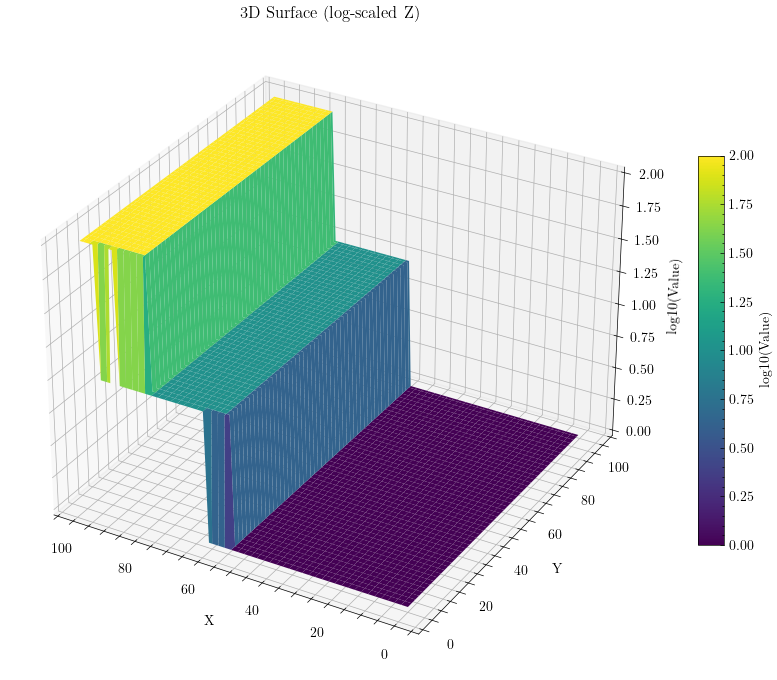

In [77]:
from mpl_toolkits.mplot3d import Axes3D   # needed for 3D projection

# Example matrix (replace with yours)
# Z = Cs[10:, 10:] - C_exact
Z = mems

# Create X, Y grid
x = np.arange(Z.shape[1])
y = np.arange(Z.shape[0])
X, Y = np.meshgrid(x, y)

# Log scale (safe: avoids log(0))
Z_log = Z

# Plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X, Y, Z_log,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("log10(Value)")
ax.set_title("3D Surface (log-scaled Z)")
# ax.set_zscale('log')

ax.invert_xaxis()

fig.colorbar(surf, shrink=0.6, aspect=15, label="log10(Value)")

plt.tight_layout()
plt.show()

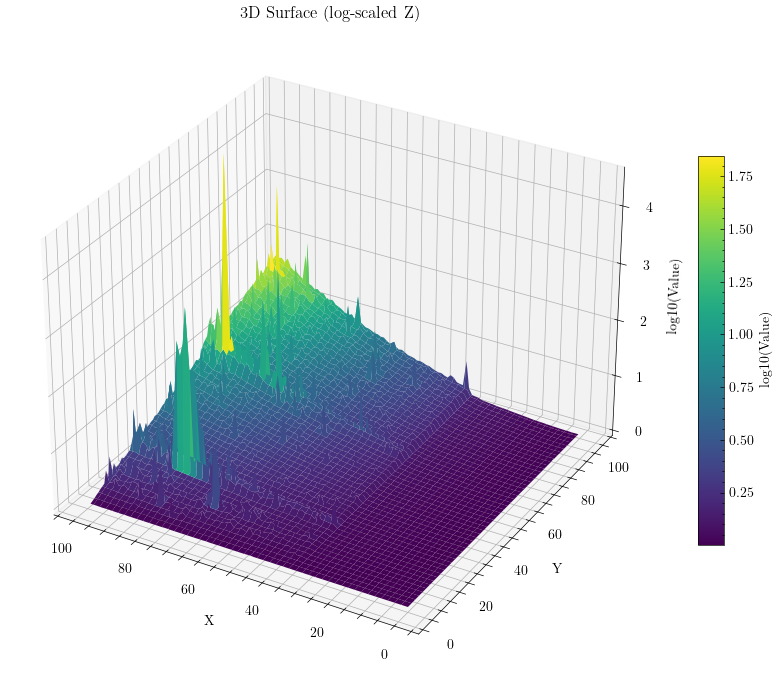

In [78]:
# Example matrix (replace with yours)
# Z = Cs[10:, 10:] - C_exact
Z = times

# Create X, Y grid
x = np.arange(Z.shape[1])
y = np.arange(Z.shape[0])
X, Y = np.meshgrid(x, y)

# Log scale (safe: avoids log(0))
Z_log = Z

# Plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X, Y, Z_log,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("log10(Value)")
ax.set_title("3D Surface (log-scaled Z)")
# ax.set_zscale('log')

ax.invert_xaxis()

fig.colorbar(surf, shrink=0.6, aspect=15, label="log10(Value)")

plt.tight_layout()
plt.show()

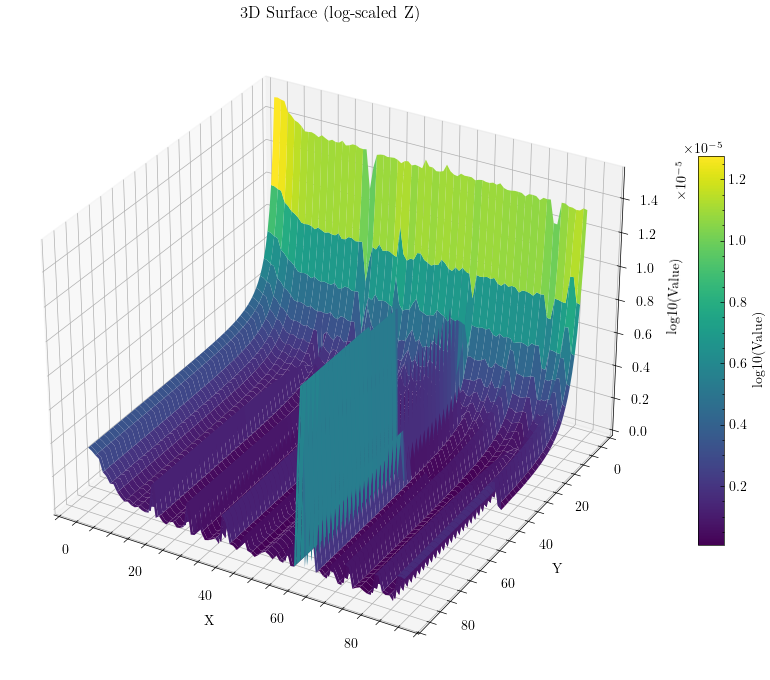

In [82]:
# Example matrix (replace with yours)
Z = np.abs(Cs[10:, 10:] - C_exact)
# Z = mems

# Create X, Y grid
x = np.arange(Z.shape[1])
y = np.arange(Z.shape[0])
X, Y = np.meshgrid(x, y)

# Log scale (safe: avoids log(0))
Z_log = Z

# Plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    X, Y, Z_log,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("log10(Value)")
ax.set_title("3D Surface (log-scaled Z)")
# ax.set_zscale('log')

ax.invert_yaxis()

fig.colorbar(surf, shrink=0.6, aspect=15, label="log10(Value)")

plt.tight_layout()
plt.show()

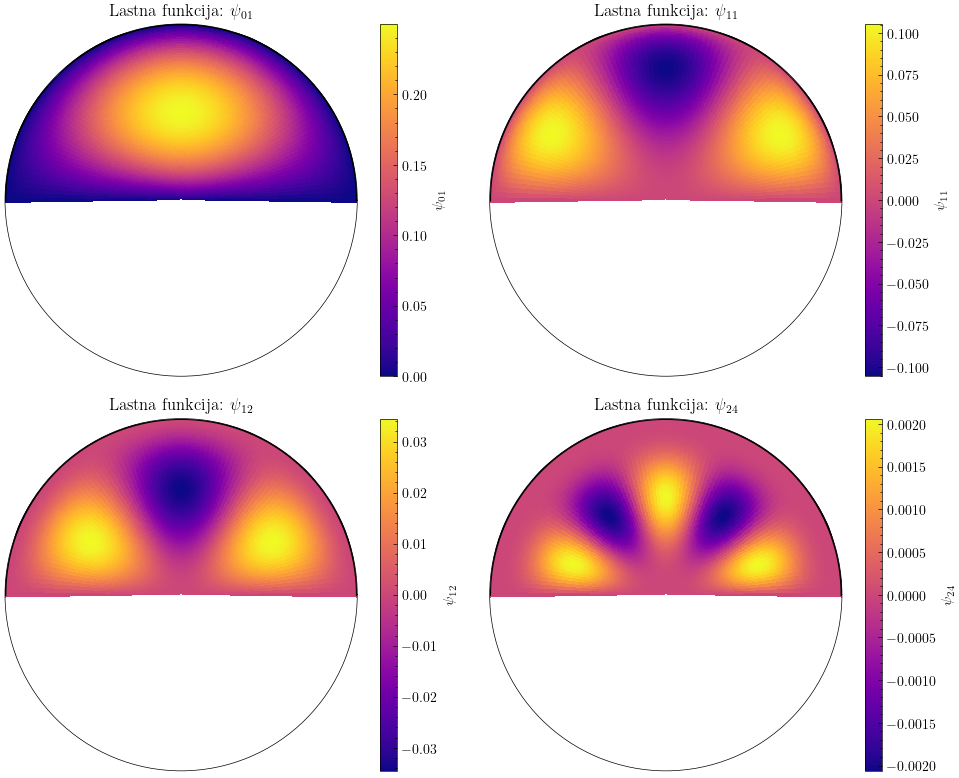

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function psi_mn
def psi_mn(xi, phi, m, n):
    return xi**(2*m+1) * (1 - xi)**n * np.sin((2*m+1)*phi)

# Generate meshgrid for xi and phi
xi_vals = np.linspace(0, 1, 100)
phi_vals = np.linspace(0, np.pi, 100)
xi, phi = np.meshgrid(xi_vals, phi_vals)

# Values for m and n for the 2x2 grid
mn_values = [(0, 1), (1, 1), (1, 2), (2, 4)]

# Set up the polar plot in a 2x2 grid
fig, axs = plt.subplots(2, 2, subplot_kw={'polar': True}, figsize=(10, 8))

for ax, (m, n) in zip(axs.flat, mn_values):
    # Calculate psi_mn for the given m, n
    psi = psi_mn(xi, phi, m, n)
    
    c = ax.pcolormesh(phi, xi, psi, cmap='plasma')
    
    ax.plot(phi_vals, np.ones_like(phi_vals), color='black', linewidth=2)
    ax.set_ylim(0, 1)
    ax.set_title(f'Lastna funkcija: $\\psi_{{{m}{n}}}$')
    # hide axis and labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

    fig.colorbar(c, ax=ax, label=f'$\\psi_{{{m}{n}}}$')

plt.tight_layout()
plt.show()

<>:29: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:29: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/tmp/ipykernel_28297/1772063350.py:29: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  plt.colorbar(c, label='$u( \\xi, \phi)$')


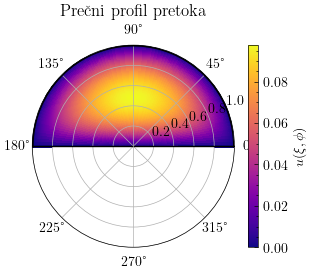

In [86]:


M, N = 100, 100
A = make_A(M, N)
b = make_b(M, N)
a = np.linalg.solve(A, b)
a_ij = a.copy().reshape(M, N)

def u(xi, phi, a_ij):
    u = 0
    for m in range(M):
        for n in range(1, N+1):
            u += a_ij[m, n-1] * psi_mn(xi, phi, m, n)
    return u

xi_vals = np.linspace(0, 1, 100)
phi_vals = np.linspace(0, np.pi, 100)
xi, phi = np.meshgrid(xi_vals, phi_vals)

u_vals = u(xi, phi, a_ij)

r = np.full_like(phi_vals, 1)
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
c = ax.pcolormesh(phi, xi, u_vals, cmap='plasma')
plt.plot(phi_vals, r, color='black', linewidth=2)
plt.plot(np.full_like(phi_vals, 0), np.linspace(-1, 1, 100), color='black', linewidth=1)
plt.plot(np.full_like(phi_vals, -np.pi), np.linspace(-1, 1, 100), color='black', linewidth=1)
plt.ylim(0, 1)
plt.title('Prečni profil pretoka')
plt.colorbar(c, label='$u( \\xi, \phi)$')
plt.show()

